# Lesson 9: Image Analysis

Last lesson we discussed a few basic tools of machine learning (clustering analysis and kernel density estimation). Many people expressed interest in performing the kinds of predition/regression analysis on images and using images is a common part of astronomy (like analyzing data from a telescope!)

## Basics/Review

Some review of the analysises we did in previous lessons/homeworks

Populating the interactive namespace from numpy and matplotlib


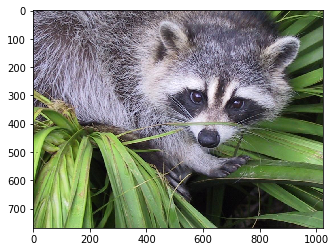

In [10]:
%pylab inline
from scipy import misc
f = misc.face()

imshow(f)
show()


In [14]:
f.shape

(768, 1024, 3)

While for real analysis color definitely helps a lot, in this case lets greyscale the image. We can do this by summing up the color information.

In [20]:
grey = f.sum(axis=2)

grey.shape

(768, 1024)

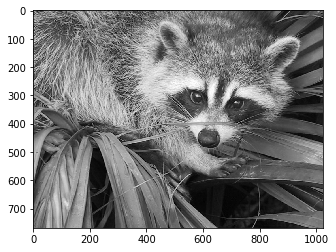

In [22]:
imshow(grey,cmap=cm.gray)

(-0.5, 1023.5, 767.5, -0.5)

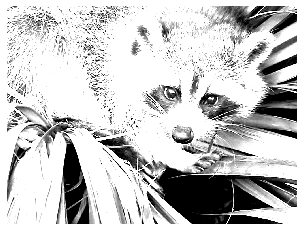

In [26]:
plt.imshow(grey, cmap=plt.cm.gray, vmin=100, vmax=300)  #high contrast racoon!
plt.axis('off') #remove ticks

One of the common tasks done in image analysis is segmentation, or splitting the image into different parts of interest. Perhaps the simplest way of doing that is by drawing contor lines. 

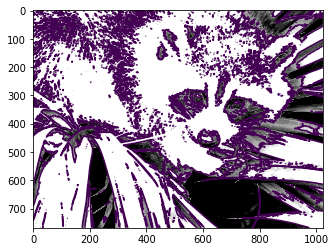

In [32]:
plt.imshow(grey, cmap=plt.cm.gray, vmin=100, vmax=300)  #high contrast racoon!
plt.contour(grey, [250]) 
#less cute racoon

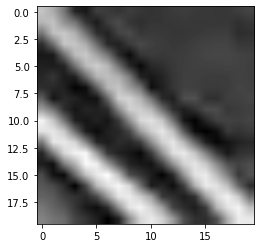

In [36]:
plt.imshow(grey[320:340, 510:530],cmap=plt.cm.gray, interpolation='bilinear') 
#zooming into an area and using an interpolation algorithm to smooth it out!

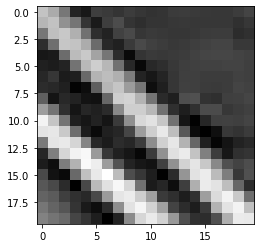

In [37]:
plt.imshow(grey[320:340, 510:530],cmap=plt.cm.gray, interpolation='nearest') 

## Masking

As in the homework (with finding Yosemite Valley), lets say we only want to only analyze part of a picture.

In [41]:
lx, ly = grey.shape
print(lx,ly)
X, Y = np.ogrid[0:lx, 0:ly]
print(X.shape,Y.shape)

768 1024
(768, 1) (1, 1024)


In [60]:
mask = (X - lx / 2) ** 2 + (Y - ly / 2) ** 2 > lx * ly / 4 #circle-like mask

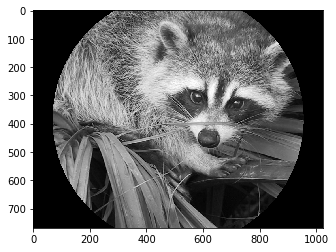

In [61]:
imshow(grey*(1-mask),cmap=plt.cm.gray)

In [66]:
mask = grey < 450

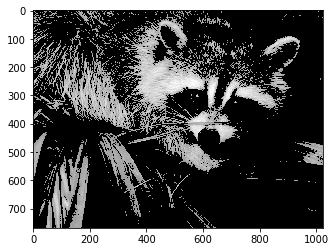

In [67]:
imshow(grey*(1-mask),cmap=plt.cm.gray)

## Basic statistical properties

(array([ 67207.,  61847.,  96962., 125411., 127362., 113536., 102023.,
         56140.,  29698.,   6246.]),
 array([  1. ,  77.1, 153.2, 229.3, 305.4, 381.5, 457.6, 533.7, 609.8,
        685.9, 762. ]),
 <a list of 10 Patch objects>)

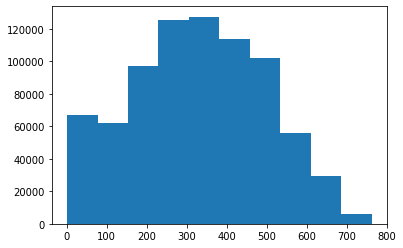

In [55]:
grey.max(), grey.min()
hist(grey.flatten())

## Geometric Transformations

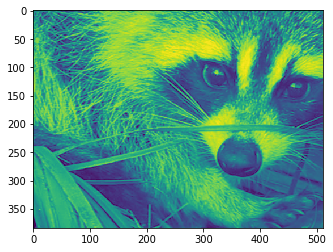

In [69]:
crop_face = grey[lx // 4: - lx // 4, ly // 4: - ly // 4]
imshow(crop_face)

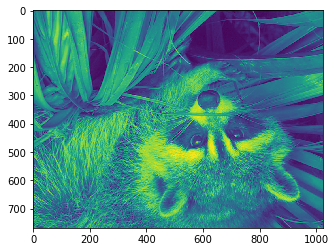

In [71]:
imshow(np.flipud(grey))

A new subpackage of scipy; ndimage!

Useful for manipulating n-dimensional images (hence "nd"-image), it includes various manipulation and filtering routines for images.

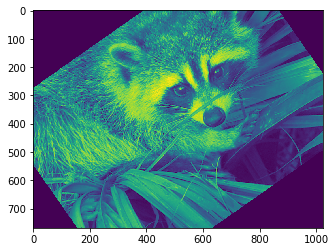

In [77]:
from scipy import ndimage
imshow(ndimage.rotate(grey, 35,reshape=False))

## Filtering

In the previous sections we simply did basic manipulations and masking, but didn't really do anything "interesting" to the pixels. In this section we will perform advanced filtering on the image.

The basis of most filterings is a convolution, where we go over the image with some given functional shape. Below is the continious one-dimensional example:

$$(f * g)(t) \triangleq\ \int_{-\infty}^\infty f(\tau) g(t - \tau) \, d\tau.$$


![alt text](https://upload.wikimedia.org/wikipedia/commons/thumb/2/21/Comparison_convolution_correlation.svg/1920px-Comparison_convolution_correlation.svg.png "Title")

For a cute animation see [here](https://en.wikipedia.org/wiki/File:Convolution_of_box_signal_with_itself2.gif)

So lets perform a smoothing of our squirrel image. First lets do so using straight numpy.

In [79]:
filt = np.array([[1,1,1],[1,2,1],[1,1,1]])
print(filt)

[[1 1 1]
 [1 2 1]
 [1 1 1]]


In [97]:
def smoothing(grey):
    smoothed = np.zeros([lx,ly])
    for i in range(3,lx-3):
        for j in range(3,ly-3):
            smoothed[i,j] = np.sum(filt*grey[i-1:i+2,j-1:j+2])
    return smoothed

In [100]:
smoothed = smoothing(smoothing(smoothing(smoothing(grey))))

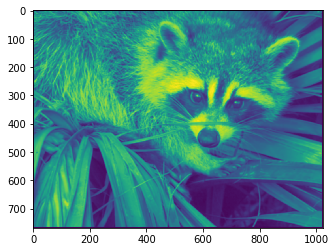

In [104]:
imshow(smoothed) #notice how the racoon is a bit smoothed out, look at the hair!

Of course we don't need to write a (very inefficient) numpy routine to do this, and we can instead use built in routines

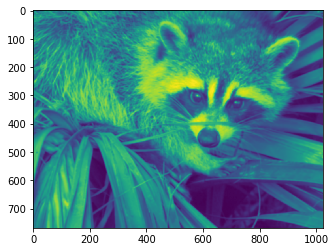

In [107]:
imshow(ndimage.gaussian_filter(grey,2)) #much faster, and neater!

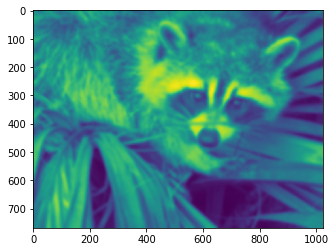

In [112]:
blurred_face = ndimage.gaussian_filter(grey,5)
imshow(blurred_face) #artsy squirrel

Note that there is some ambigiouity as to what to do on the boundary. By default ndimage will use a reflection of the image, but sometimes you will want to instead wrap the image (so it uses values on the other side). Check out the docstring for more info (ndimage.gaussian_filter?))

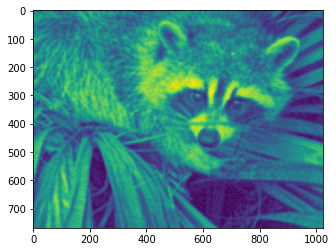

In [117]:
#sharpening 
blurred_face_n = ndimage.gaussian_filter(blurred_face,1)

sharpened = blurred_face + 30 * (blurred_face - blurred_face_n)

imshow(sharpened) #a bit sharper of an image?

## Noise/Denoise

Most images have some noise... Here we will assume "white noise" i.e. noise drawn from a gaussian.

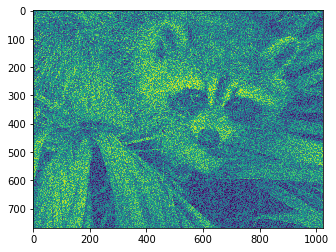

In [132]:
f = misc.face(gray=True)

noisy = f + 4 * f.std() * np.random.random(f.shape)
imshow(noisy)

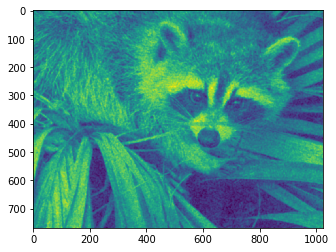

In [135]:
gauss_denoised = ndimage.gaussian_filter(noisy, 2) #smoothed image is less sensitive to noise

imshow(gauss_denoised)

If you have more complex noise properties (non-white) you might want to try a Weiner filtering (see scipy.signal.wiener).

## Feature Extraction

If running a regression/clustering analysis we will want to extract specific features of an image to pass to our model.

# Edge detection

Find sharp edges of an image. These algorithms usually work by finding sharp transitions via using the gradient

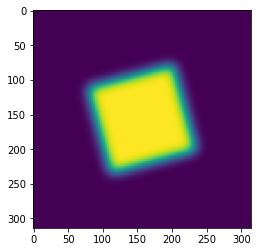

In [138]:
im = np.zeros((256, 256))
im[64:-64, 64:-64] = 1 #square

im = ndimage.rotate(im, 15, mode='constant') #rotate
im = ndimage.gaussian_filter(im, 8) #blurr

imshow(im)

In [141]:
edges = ndimage.sobel(im, mode='constant')

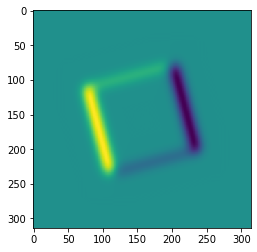

In [142]:
imshow(edges)

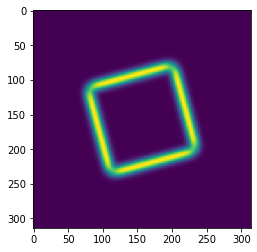

In [147]:
#making it a bit prettier
sx = ndimage.sobel(im, axis=0)
sy = ndimage.sobel(im, axis=1)

sob = np.power(sx,2) + np.power(sy,2)

imshow(sob)

### Segmentation and seperating components

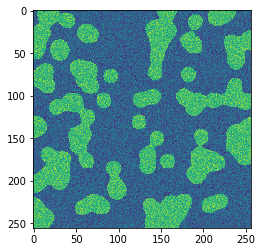

In [155]:

#initializing a field of random blobs
n = 10
l = 256
im = np.zeros((l, l))
np.random.seed(1)
points = l*np.random.random((2, n**2))
im[(points[0]).astype(np.int), (points[1]).astype(np.int)] = 1
im = ndimage.gaussian_filter(im, sigma=l/(4.*n))
mask = (im > im.mean()).astype(np.float)
mask += 0.1 * im
img = mask + 0.2*np.random.randn(*mask.shape)

imshow(img)


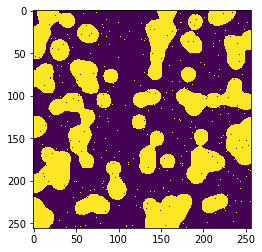

In [156]:
hist, bin_edges = np.histogram(img, bins=60)
bin_centers = 0.5*(bin_edges[:-1] + bin_edges[1:])
binary_img = img > 0.5
imshow(binary_img)

# Measuring Object Properties

Lets find connected components!


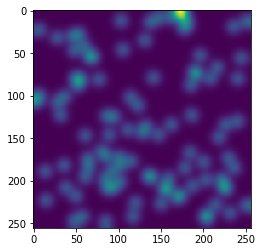

In [159]:

n = 10
l = 256
im = np.zeros((l, l))
points = l*np.random.random((2, n**2))
im[(points[0]).astype(np.int), (points[1]).astype(np.int)] = 1
im = ndimage.gaussian_filter(im, sigma=l/(4.*n))
mask = im > im.mean()
imshow(im)

In [162]:
label_im, nb_labels = ndimage.label(mask)
print(nb_labels) #how many connected components?

22


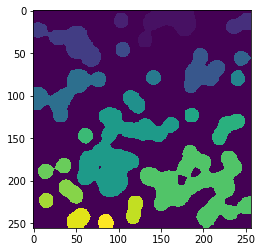

In [163]:
plt.imshow(label_im)

In [164]:
sizes = ndimage.sum(mask, label_im, range(nb_labels + 1))
mean_vals = ndimage.sum(im, label_im, range(1, nb_labels + 1))